In [1]:
#Importamos las librerias que vamos a usar.

import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns


from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importamos el DF de US Accidents (2016 - 2021) ya limpiado.

ruta1 = r'C:\Users\manue\Desktop\Evaluacion Tecnica Analista Sr - Consultor BDS\peajes_caba.csv'
ruta2 = r'C:\Users\nanomanu\Desktop\Evaluacion Tecnica Analista Sr - Consultor BDS\peajes_caba.csv'
df = pd.read_csv(ruta2)
display(df.head(3))
print('Este Dataset tiene', df.shape[0], 'filas y',df.shape[1],'columnas.')

,estacion,fecha,cantidad_pasos
0,alberdi,1/1/2016,5446.0
1,alberdi,1/2/2016,6927.0
2,alberdi,1/3/2016,6630.0


Este Dataset tiene 1461 filas y 3 columnas.


In [3]:
#Averiguo los tipos de datos del DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   estacion        1461 non-null   object 
 1   fecha           1461 non-null   object 
 2   cantidad_pasos  1277 non-null   float64
dtypes: float64(1), object(2)
memory usage: 34.4+ KB


In [4]:
#Averiguo si tiene nulos
df.isnull().sum()

estacion            0
fecha               0
cantidad_pasos    184
dtype: int64

In [5]:
#Creo una funcion para convertir la columna "fecha" al tipo "datatime64".

from dateutil import parser

def parse(x):
   
    mo, dd, yyyy = x.split('/')
    return parser.parse("%s %s %s" % (yyyy,mo,dd))


df['fecha'] = df['fecha'].apply(lambda x : parse(x))

In [6]:
#Observo los tipos de datos nuevamente para verificar que se realizó el cambio.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   estacion        1461 non-null   object        
 1   fecha           1461 non-null   datetime64[ns]
 2   cantidad_pasos  1277 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.4+ KB


In [7]:
#Vizualizo las principales medidas de estadística descriptiva.
print('Principales medidas de estadística descriptiva: \n\n',round(df.describe(),2))
print('\nOtras medidas de estadística descriptiva: \n', '\nVarianza: ',round(df['cantidad_pasos'].var(),2),'\nMediana: ', round(df['cantidad_pasos'].median(),2),'\nTotal de pasos: ', round(df['cantidad_pasos'].sum(),2))

Principales medidas de estadística descriptiva: 

        cantidad_pasos
count         1277.00
mean          9223.98
std           1629.20
min           4094.00
25%           8539.00
50%           9672.00
75%          10364.00
max          12687.00

Otras medidas de estadística descriptiva: 
 
Varianza:  2654279.62 
Mediana:  9672.0 
Total de pasos:  11779025.0


In [8]:
#Busco los principales datos repetidos
df.cantidad_pasos.value_counts().head(5)

9682.0     4
9997.0     4
10532.0    4
9880.0     3
9673.0     3
Name: cantidad_pasos, dtype: int64

In [9]:
# Descomposición estacional
df_info_completa = df.loc[(df['fecha'] >='2016-01-01') & (df['fecha'] <= '2019-06-30')]
y = df_info_completa[['fecha', 'cantidad_pasos']].set_index('fecha')
y = y['cantidad_pasos'].resample('MS').mean()

<Figure size 1152x720 with 0 Axes>

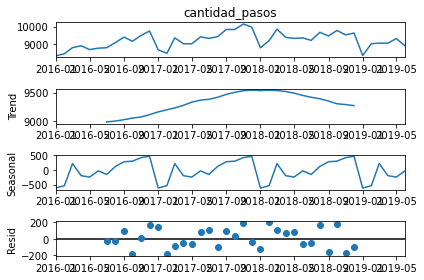

In [10]:
import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [11]:
#Desgolozo la columna fecha para utilizarlo en los proximos graficos.
df['Dia'] = df['fecha'].dt.dayofweek 
df['Dia'] = df['fecha'].dt.day_name()
df['Month'] = df['fecha'].dt.strftime('%b') 
days = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6} 
df['numero'] = df['Dia'].apply(lambda x: days[x])
df['Year'] = df['fecha'].dt.year
df

,estacion,fecha,cantidad_pasos,Dia,Month,numero,Year
0,alberdi,2016-01-01,5446.0,Friday,Jan,4,2016
1,alberdi,2016-01-02,6927.0,Saturday,Jan,5,2016
2,alberdi,2016-01-03,6630.0,Sunday,Jan,6,2016
3,alberdi,2016-01-04,9835.0,Monday,Jan,0,2016
4,alberdi,2016-01-05,9091.0,Tuesday,Jan,1,2016
...,...,...,...,...,...,...,...
1456,alberdi,2019-12-27,NaN,Friday,Dec,4,2019
1457,alberdi,2019-12-28,NaN,Saturday,Dec,5,2019
1458,alberdi,2019-12-29,NaN,Sunday,Dec,6,2019
1459,alberdi,2019-12-30,NaN,Monday,Dec,0,2019


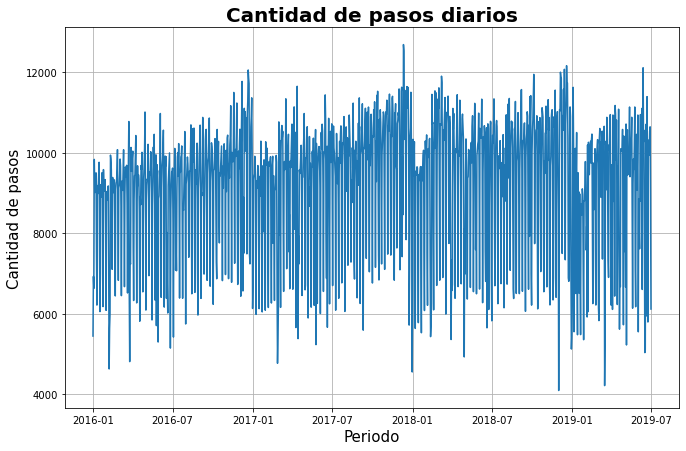

In [12]:
#Vizualizo las pasos diarios del DF.

plt.figure(figsize = (11,7))
plt.plot( df['fecha'], df['cantidad_pasos'])
plt.title('Cantidad de pasos diarios', size=20, color='black',weight = 'bold')
plt.xlabel('Periodo',size=15, color='black')
plt.ylabel('Cantidad de pasos',size=15, color='black')
plt.grid()
plt.show()

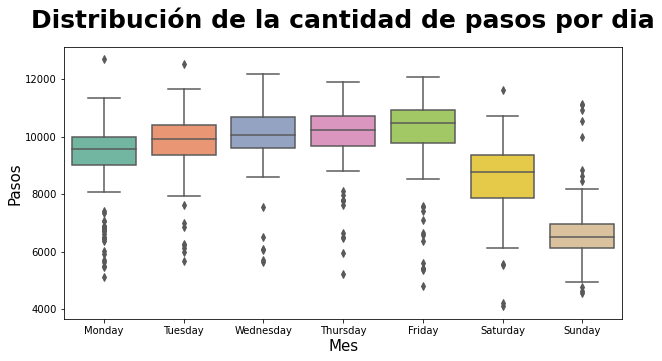

In [13]:
#Vizualizo de los pasos por día del DF.

plt.figure(figsize=(10,5))
sns.boxplot(data=df, 
            x="Dia", 
            y="cantidad_pasos",
            palette="Set2",
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            dodge=False)
plt.xlabel('Mes', size=15, labelpad=3)
plt.ylabel('Pasos', size=15, labelpad=3)
plt.title('Distribución de la cantidad de pasos por dia', size=25, color='black',weight = 'bold',y=1.05);
plt.show()

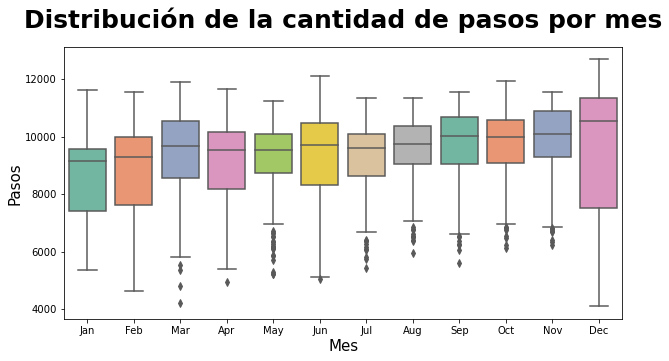

In [14]:
#Vizualizo de los pasos por mes del DF.

plt.figure(figsize=(10,5))
sns.boxplot(data=df, 
            x="Month", 
            y="cantidad_pasos",
            palette="Set2", 
            dodge=False)
plt.xlabel('Mes', size=15, labelpad=3)
plt.ylabel('Pasos', size=15, labelpad=3)
plt.title('Distribución de la cantidad de pasos por mes', size=25, color='black',weight = 'bold',y=1.05);
plt.show()

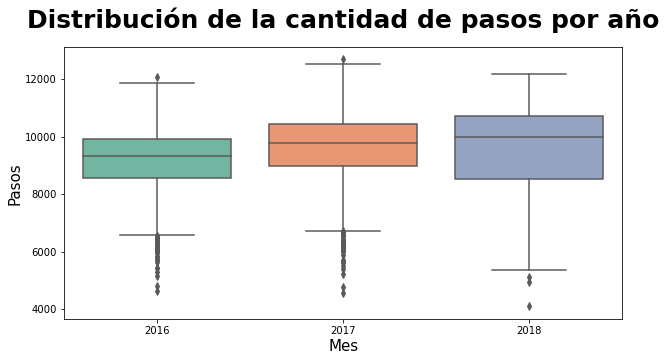

In [15]:
#Vizualizo de los pasos por año completo del DF.

plt.figure(figsize=(10,5))
sns.boxplot(data=df[(df.Year != 2019)], 
            x="Year", 
            y="cantidad_pasos",
            palette="Set2", 
            dodge=False)
plt.xlabel('Mes', size=15, labelpad=3)
plt.ylabel('Pasos', size=15, labelpad=3)
plt.title('Distribución de la cantidad de pasos por año', size=25, color='black',weight = 'bold',y=1.05);
plt.show()

SQL

In [ ]:
mydb = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'xxxxxx',
    database = 'Evaluación_Técnica'
)

In [ ]:
# Creo la función 

mycursor = mydb.cursor()

def sql(yourQuery):
    mycursor.execute(yourQuery)
    myresult = mycursor.fetchall()
    df2 = pd.DataFrame(myresult, columns = mycursor.column_names)
    return df2

In [ ]:
# Pruebo la funcion creada

sql(
    '''
    SELECT *
    FROM peajes_caba;
    '''
)

In [ ]:
#creo que query
sql(
    '''
    WITH daily_avg_cantidad_pasos AS
        (SELECT
            date_format(fecha, '%m-%d') dia,
            avg(cantidad_pasos) avg_cantidad_pasos
        FROM 
            peajes_caba
        GROUP BY
            dia
        )

    SELECT dia, avg_cantidad_pasos
    FROM daily_avg_cantidad_pasos
    WHERE dia BETWEEN ('07-01') and ('12-31')
    ORDER BY dia;
    '''
)

<h3> PYTHON

<h3> Modelo Prophet

In [16]:
#Creo un df nuevo para usar el modelo nuevo que voy a correr

df_prophet = df.loc[(df['fecha'] >='2016-01-01') & (df['fecha'] <= '2019-06-30')]
df_prophet = df_prophet.rename(columns= {'fecha': 'ds' , 'cantidad_pasos': 'y' } )
df_prophet

,estacion,ds,y,Dia,Month,numero,Year
0,alberdi,2016-01-01,5446.0,Friday,Jan,4,2016
1,alberdi,2016-01-02,6927.0,Saturday,Jan,5,2016
2,alberdi,2016-01-03,6630.0,Sunday,Jan,6,2016
3,alberdi,2016-01-04,9835.0,Monday,Jan,0,2016
4,alberdi,2016-01-05,9091.0,Tuesday,Jan,1,2016
...,...,...,...,...,...,...,...
1272,alberdi,2019-06-26,10064.0,Wednesday,Jun,2,2019
1273,alberdi,2019-06-27,10532.0,Thursday,Jun,3,2019
1274,alberdi,2019-06-28,10644.0,Friday,Jun,4,2019
1275,alberdi,2019-06-29,8892.0,Saturday,Jun,5,2019


In [17]:
#Entrenamos el modelo
modelo = Prophet()
modelo.fit(df_prophet)

18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
#creo el forcast hasta la fecha solicitada.
future = modelo.make_future_dataframe(periods=184)
prediccion = modelo.predict(future)
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prediccion.tail()

#Creo un df para medir 
prediccion_comparacion = prediccion.loc[(prediccion['ds'] >='2016-01-01') & (prediccion['ds'] <= '2019-06-30')]

#Creo un df para tener los resultados 
forecast = prediccion.loc[(prediccion['ds'] >= '2019-07-01') & (prediccion['ds'] <= '2019-12-31')].reset_index(drop=True)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01,9135.445391,7644.587400,10097.557237,9135.445391,9135.445391,-230.962034,-230.962034,-230.962034,13.723152,13.723152,13.723152,-244.685185,-244.685185,-244.685185,0.0,0.0,0.0,8904.483357
1,2019-07-02,9134.600912,8192.389707,10725.368569,9134.600912,9134.600912,311.455730,311.455730,311.455730,550.939640,550.939640,550.939640,-239.483910,-239.483910,-239.483910,0.0,0.0,0.0,9446.056642
2,2019-07-03,9133.756433,8452.272527,11082.260912,9133.756433,9133.756433,589.798739,589.798739,589.798739,822.336481,822.336481,822.336481,-232.537742,-232.537742,-232.537742,0.0,0.0,0.0,9723.555172
3,2019-07-04,9132.911954,8400.155357,11154.804825,9132.911954,9132.911954,648.501758,648.501758,648.501758,872.411279,872.411279,872.411279,-223.909520,-223.909520,-223.909520,0.0,0.0,0.0,9781.413712
4,2019-07-05,9132.067474,8621.826150,11187.634367,9132.067474,9132.067474,771.263315,771.263315,771.263315,984.957716,984.957716,984.957716,-213.694401,-213.694401,-213.694401,0.0,0.0,0.0,9903.330789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2019-12-27,8984.283603,8738.233640,11408.473226,8961.086565,9008.919231,1092.306057,1092.306057,1092.306057,984.957716,984.957716,984.957716,107.348341,107.348341,107.348341,0.0,0.0,0.0,10076.589659
180,2019-12-28,8983.439124,6999.654432,9644.718581,8960.045467,9008.345541,-627.369965,-627.369965,-627.369965,-631.888397,-631.888397,-631.888397,4.518431,4.518431,4.518431,0.0,0.0,0.0,8356.069158
181,2019-12-29,8982.594644,4928.526730,7605.186382,8958.982064,9007.803753,-2710.187090,-2710.187090,-2710.187090,-2612.479870,-2612.479870,-2612.479870,-97.707220,-97.707220,-97.707220,0.0,0.0,0.0,6272.407554
182,2019-12-30,8981.750165,7545.444367,10142.996064,8957.961646,9007.155847,-184.207757,-184.207757,-184.207757,13.723152,13.723152,13.723152,-197.930909,-197.930909,-197.930909,0.0,0.0,0.0,8797.542408


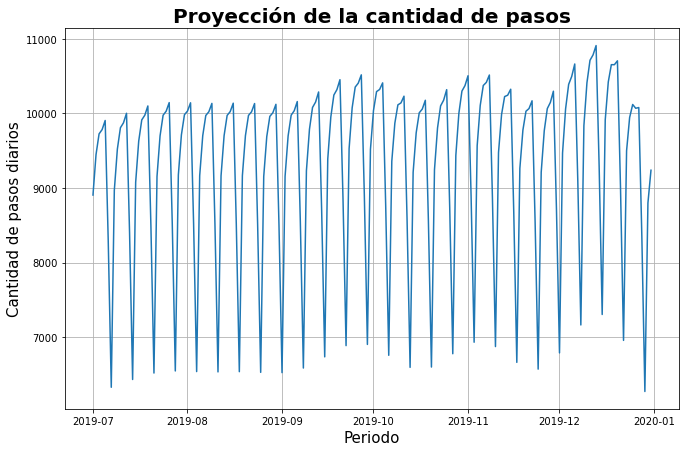

In [19]:
#Vizualizo las pasos diarios del DF.

plt.figure(figsize = (11,7))
plt.plot( forecast['ds'], forecast['yhat'])
plt.title('Proyección de la cantidad de pasos', size=20, color='black',weight = 'bold')
plt.xlabel('Periodo',size=15, color='black')
plt.ylabel('Cantidad de pasos diarios',size=15, color='black')
plt.grid()
plt.show()

In [20]:
#métricas de rendimiento
print('Métricas de rendimiento del modelo:')
print("R2 (Explicacion de la Varianza):", round(r2_score(df_info_completa.cantidad_pasos, prediccion_comparacion.yhat), 2))
print("Porcentaje Error Absoluto Medio (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((np.array(df_info_completa.cantidad_pasos)-prediccion_comparacion['yhat'])/prediccion_comparacion['yhat'])), 2))
print("Error Absoluto Medio (Σ|y-pred|/n):", "{:,.0f}".format(mean_absolute_error(df_info_completa.cantidad_pasos, prediccion_comparacion.yhat)))
print("Error Cuadratico Medio (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(df_info_completa.cantidad_pasos, prediccion_comparacion.yhat))))


Métricas de rendimiento del modelo:
R2 (Explicacion de la Varianza): 0.61
Porcentaje Error Absoluto Medio (Σ(|y-pred|/y)/n): 0.07
Error Absoluto Medio (Σ|y-pred|/n): 653
Error Cuadratico Medio (sqrt(Σ(y-pred)^2/n)): 1,015


In [21]:
#Creo un df nuevo para usar el modelo nuevo que voy a correr

df_prophet_optimizado = df.loc[(df['fecha'] >='2016-01-01') & (df['fecha'] <= '2019-06-30')]
df_prophet_optimizado = df_prophet.rename(columns= {'fecha': 'ds' , 'cantidad_pasos': 'y' } )
df_prophet_optimizado

,estacion,ds,y,Dia,Month,numero,Year
0,alberdi,2016-01-01,5446.0,Friday,Jan,4,2016
1,alberdi,2016-01-02,6927.0,Saturday,Jan,5,2016
2,alberdi,2016-01-03,6630.0,Sunday,Jan,6,2016
3,alberdi,2016-01-04,9835.0,Monday,Jan,0,2016
4,alberdi,2016-01-05,9091.0,Tuesday,Jan,1,2016
...,...,...,...,...,...,...,...
1272,alberdi,2019-06-26,10064.0,Wednesday,Jun,2,2019
1273,alberdi,2019-06-27,10532.0,Thursday,Jun,3,2019
1274,alberdi,2019-06-28,10644.0,Friday,Jun,4,2019
1275,alberdi,2019-06-29,8892.0,Saturday,Jun,5,2019


In [22]:

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.3,0.5],
              'holidays_prior_scale':[0.1,0.3,0.5],
              'n_changepoints' : [50,100,150]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Total Possible Models 54


In [23]:
import random
strt='2016-01-01'
end='2019-06-30'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         interval_width=0.95)
    train_model.fit(df_prophet_optimizado)
    train_forecast = train_model.make_future_dataframe(periods=1277, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['fecha']>=strt) & (df['fecha']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['cantidad_pasos'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.256165348528352
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.464666640636743
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.238769958690327
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.458967673072074
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.259236792557488
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:51:28 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.46152613756292
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.256165348528352
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.464666640636743
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.238769958690327
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.458967673072074
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.259236792557488
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.46152613756292
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.256165348528352
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.464666640636743
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.238769958690327
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.458967673072074
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.259236792557488
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.46152613756292
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.05675837042478
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.039209878245178
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.966408142969293
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.051868032229617
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:51:53 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.872889125298776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.019516840668267
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.05675837042478
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.039209878245178
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.966408142969293
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.051868032229617
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.872889125298776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.019516840668267
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.05675837042478
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.039209878245178
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.966408142969293
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.051868032229617
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.872889125298776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.019516840668267
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 24.24689597929485
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.016359920170444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.747616345162477
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.027802369808565
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 25.912238476965534
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.033402785396238
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 24.24689597929485
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.016359920170444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.747616345162477
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.027802369808565
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 25.912238476965534
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.033402785396238
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 24.24689597929485
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.016359920170444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 22.747616345162477
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


18:52:45 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.027802369808565
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 25.912238476965534
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 23.033402785396238


In [24]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,22.747616,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,22.747616,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,22.747616,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,22.872889,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
4,22.872889,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."


In [25]:
print('Mejor Parametros:')
parameters['Parameters'][0]

Mejor Parametros:


{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [26]:
final_model = Prophet(changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      interval_width=0.95)
final_model.fit(df_prophet_optimizado)

18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = final_model.make_future_dataframe(periods=184)
prediccion_optimizado = final_model.predict(future)
prediccion_optimizado = prediccion_optimizado[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prediccion_optimizado_comparacion = prediccion_optimizado.loc[(prediccion_optimizado['ds'] >='2016-01-01') & (prediccion_optimizado['ds'] <= '2019-06-30')]
forecast_optimizado = prediccion_optimizado.loc[(prediccion_optimizado['ds'] >= '2019-07-01') & (prediccion_optimizado['ds'] <= '2019-12-31')].reset_index(drop= True)
forecast_optimizado

,ds,yhat,yhat_lower,yhat_upper
0,2019-07-01,8921.717608,6979.478936,10927.798496
1,2019-07-02,9457.454323,7486.349313,11500.329550
2,2019-07-03,9732.841463,7868.947707,11671.915674
3,2019-07-04,9789.951185,7818.978624,11780.077361
4,2019-07-05,9910.307317,7900.381777,11892.081722
...,...,...,...,...
179,2019-12-27,10089.151708,8082.777310,12116.926142
180,2019-12-28,8407.431928,6422.762238,10347.388543
181,2019-12-29,6369.770362,4447.987566,8376.938097
182,2019-12-30,8835.328214,6888.918452,10770.621583


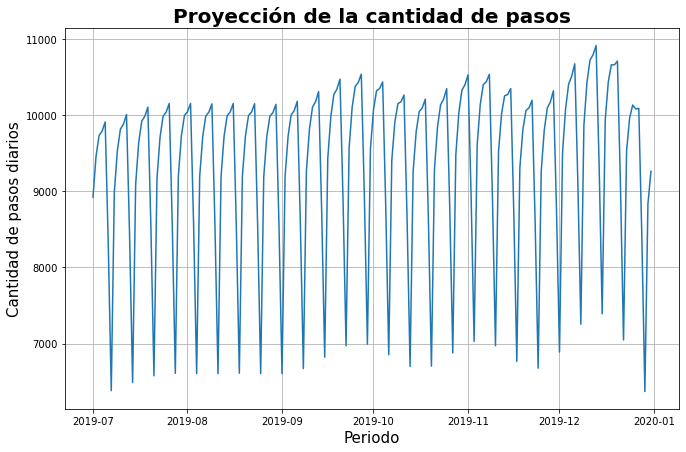

In [28]:
#Vizualizo las pasos diarios del DF.

plt.figure(figsize = (11,7))
plt.plot( forecast_optimizado['ds'], forecast_optimizado['yhat'])
plt.title('Proyección de la cantidad de pasos', size=20, color='black',weight = 'bold')
plt.xlabel('Periodo',size=15, color='black')
plt.ylabel('Cantidad de pasos diarios',size=15, color='black')
plt.grid()
plt.show()

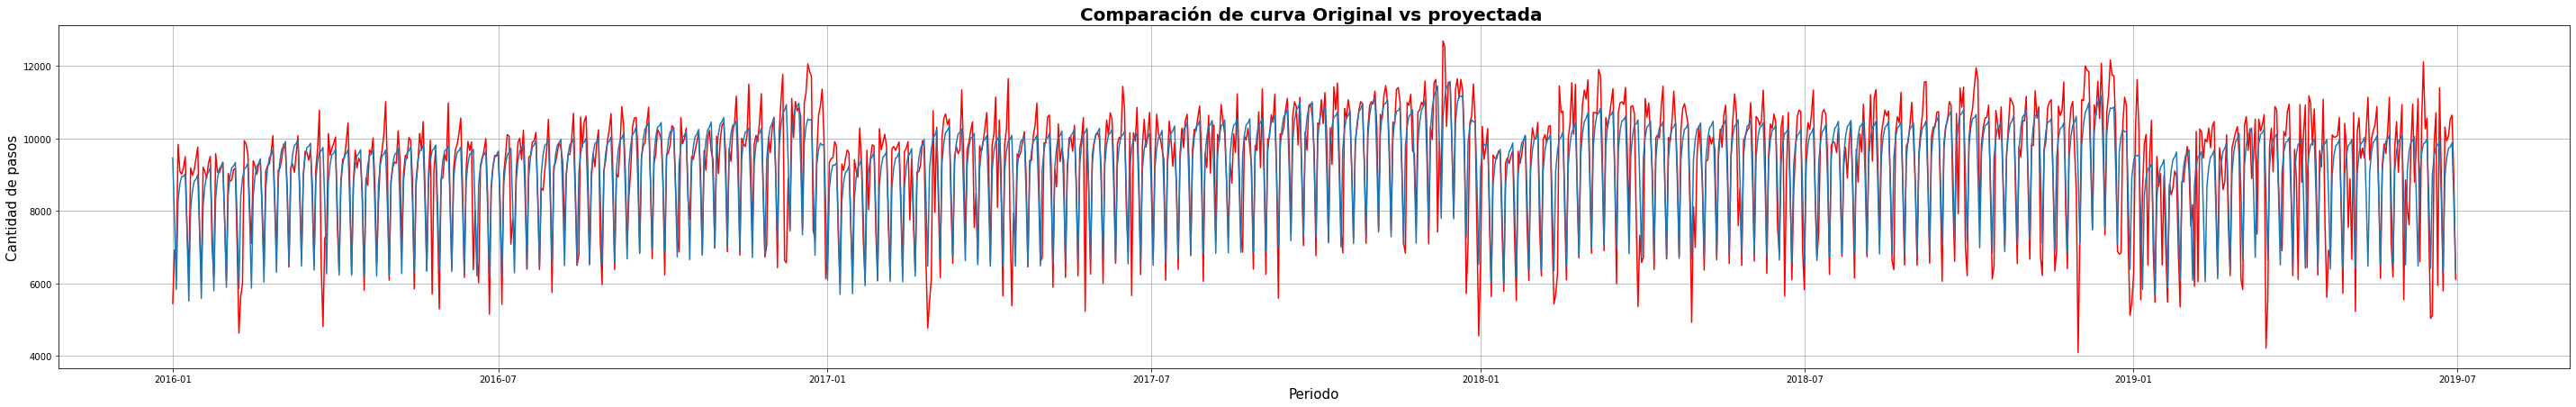

In [29]:
#Vizualizo de la comparacion entre DF original, con el DF obtenido de la oprimizacion. 
plt.figure(figsize = (50,7))
plt.plot( df_info_completa['fecha'], df_info_completa['cantidad_pasos'],color='red')
plt.plot( prediccion_optimizado_comparacion['ds'], prediccion_optimizado_comparacion['yhat'])
plt.title('Comparación de curva Original vs proyectada ', size=20, color='black',weight = 'bold')
plt.xlabel('Periodo',size=15, color='black')
plt.ylabel('Cantidad de pasos',size=15, color='black')
plt.grid()
plt.show()

In [30]:
#métricas de rendimiento
print('Métricas de rendimiento del modelo:')
print("R2 (Explicacion de la Varianza):", round(r2_score(df_info_completa.cantidad_pasos, prediccion_optimizado_comparacion.yhat), 2))
print("Porcentaje Error Absoluto Medio (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((np.array(df_info_completa.cantidad_pasos)-prediccion_optimizado_comparacion['yhat'])/prediccion_optimizado_comparacion['yhat'])), 2))
print("Error Absoluto Medio (Σ|y-pred|/n):", "{:,.0f}".format(mean_absolute_error(df_info_completa.cantidad_pasos, prediccion_optimizado_comparacion.yhat)))
print("Error Cuadratico Medio (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(df_info_completa.cantidad_pasos, prediccion_optimizado_comparacion.yhat))))


Métricas de rendimiento del modelo:
R2 (Explicacion de la Varianza): 0.62
Porcentaje Error Absoluto Medio (Σ(|y-pred|/y)/n): 0.07
Error Absoluto Medio (Σ|y-pred|/n): 644
Error Cuadratico Medio (sqrt(Σ(y-pred)^2/n)): 1,010
